In [2]:
%matplotlib inline    
import matplotlib as mplt
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import matplotlib
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
# matplotlib.style.use('ggplot')

from utils_libs import *
from utils_data_prep import *

from scipy.stats import lognorm
from scipy.stats import norm
# from scipy.stats import chisqprob

from numpy import prod
import seaborn as sns

# statiscal models
import statsmodels as sm
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.api import VAR, DynamicVAR

from statsmodels.stats import diagnostic


In [4]:
import json

with open('config.json') as f:
    para = json.load(f)
    print para 

{u'para_order_hour': 16, u'para_order_minu': 30, u'interval_len': 2160, u'para_step_ahead': 0, u'roll_len': 4, u'bool_feature_selection': u'False'}


In [2]:
y_hat = np.asarray([1,3,4])
y = np.asarray([3,4,5])

print mean(abs(y_hat-y)/(y+1e-10))

0.37222222221139817


In [4]:
features_ob = [ 'spread', 'weightd spread', 'ask vol.', 'bid vol.', 'vol. diff.', 'ask depth', 'bid depth', \
               'depth diff.', 'bid slope', 'ask slope']

#depth - amount
#volumn - number of asks or bids 

# [ 'spread' + , 'weightd spread' + , 'ask vol.' + , 'bid vol.' + , 'vol. diff.' +-, 'ask depth' + , 'bid depth' +,
#                'depth diff.' +- , 'bid slope' + , 'ask slope' + ]

In [3]:
# --- Load pre-processed order book data ---

all_dta_minu = np.load("../dataset/bitcoin/dta_minu.dat")
all_loc_hour = np.load("../dataset/bitcoin/loc_hour.dat")
print len(all_dta_minu), len(all_loc_hour)

features_minu = np.load("../dataset/bitcoin/training_data/feature_minu.dat")
rvol_hour = np.load("../dataset/bitcoin/training_data/return_vol_hour.dat")
print np.shape(features_minu), np.shape(rvol_hour)

# --- Load order book data files ---

# all_dta_minu,all_loc_hour = load_raw_order_book_files('../dataset/bitcoin/order_book/*.csv', True)

701892 13729
(701892, 10) (13729,)


4.433782881922414 0.0


(array([2.20842610e+00, 3.43346764e-02, 8.04975667e-03, 2.95705347e-03,
        9.85684490e-04, 3.28561497e-04, 1.64280748e-04, 0.00000000e+00,
        0.00000000e+00, 1.64280748e-04]),
 array([0.        , 0.44337829, 0.88675658, 1.33013486, 1.77351315,
        2.21689144, 2.66026973, 3.10364802, 3.54702631, 3.99040459,
        4.43378288]),
 <a list of 10 Patch objects>)

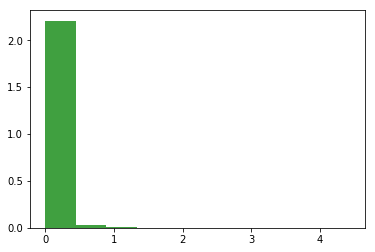

In [5]:
fig, ax = plt.subplots()
print max(rvol_hour), min(rvol_hour) 
ax.hist(rvol_hour, normed=1, facecolor='green', alpha=0.75)

# ax.plot(np.arange(0, 30),tmp)
# # , 'g', marker='o')
# #         ,  marker='o', linestyle='--', label = 'Auto-correlation', color = 'b')
# # plt.title("Order book data from one minute")
# # ax.set_ylim([-50, 400])

# ax.xaxis.set_tick_params(labelsize=15)
# ax.yaxis.set_tick_params(labelsize=15)
# ax.set_ylim([-1000, 1200])

In [9]:
print len([9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4])
print len([30, 31, 30, 31, 31, 30, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 30, 31, 30])

20
20


In [6]:
# autoregressive order 

tmp_pacf = sm.tsa.stattools.pacf(rvol_hour)[2:]
pacf_order = list(tmp_pacf).index(max(tmp_pacf))

print tmp_pacfb

[ 0.08053161  0.12617037  0.11191109  0.0448369   0.07841005  0.06935748
  0.06593615  0.01780001  0.05549493 -0.00195277  0.05386683  0.03827371
  0.06148523  0.06141611  0.06974913  0.03284848  0.08194407  0.03167015
  0.05031369  0.0469529   0.0362121   0.00489938  0.02003958  0.00553127
  0.02599063  0.01982528 -0.01327107  0.0059362  -0.00353747 -0.02198939
  0.00627139 -0.00548313 -0.01586385  0.0048113   0.0017378   0.00677278
 -0.00844166  0.02120722 -0.00060033]


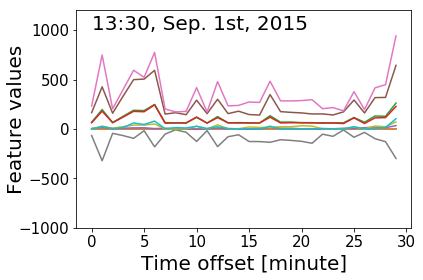

In [6]:
# FIGURE 

# order book to feature series

tmp = features_minu[500:530]

np.shape(tmp)

fig, ax = plt.subplots()
ax.plot(np.arange(0, 30),tmp)
# , 'g', marker='o')
#         ,  marker='o', linestyle='--', label = 'Auto-correlation', color = 'b')
# plt.title("Order book data from one minute")
# ax.set_ylim([-50, 400])

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylim([-1000, 1200])

ax.xaxis.set_ticks(np.arange(0, 35, 5));

ax.set_xlabel('Time offset [minute]', fontsize=20)
ax.set_ylabel('Feature values', fontsize=20)
# ax.legend(loc=2)
ax.yaxis.set_label_coords(-0.15, 0.5)

ax.text(0, 1000, '13:30, Sep. 1st, 2015', fontsize=20)


fig.savefig('/media/guo/System/Users/guoti/tian-work-2017/paper_bc/figures/ob_series.eps')

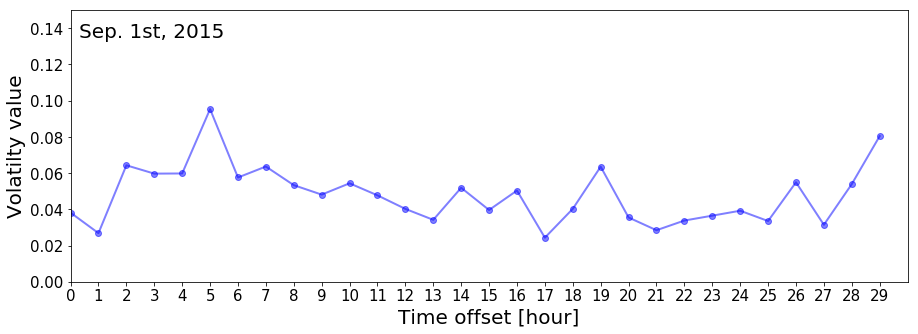

In [7]:
# FIGURE 

# sparse volatility series

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

x = [i for i in range(30)]

ax.plot(x, rvol_hour[:30], c="b", alpha=0.5, label="Luck",  marker='o', linewidth=2.0)

#         ,  marker='o', linestyle='--', label = 'Auto-correlation', color = 'b')
# plt.title("Hourly volatilty of return")

ax.xaxis.set_ticks(np.arange(0, 30))
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

ax.set_xlim([0,30])
ax.set_ylim([0,0.15])
ax.set_ylabel('Volatilty value', fontsize=20)
ax.set_xlabel('Time offset [hour]', fontsize=20)

ax.text(0.3, 0.135, 'Sep. 1st, 2015', fontsize=20)

fig.savefig('/media/guo/System/Users/guoti/tian-work-2017/paper_bc/figures/vol_minu.eps')

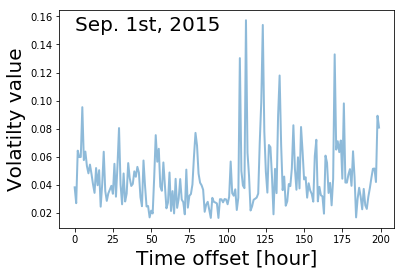

In [11]:
# FIGURE 

fig, ax = plt.subplots()
ax.plot(rvol_hour[:200], alpha=0.5, linewidth=2.0)
#         ,  marker='o', linestyle='--', label = 'Auto-correlation', color = 'b')
# plt.title("Hourly volatilty of return")

ax.set_ylabel('Volatilty value', fontsize=20)
ax.set_xlabel('Time offset [hour]', fontsize=20)

ax.text(0.3, 0.15, 'Sep. 1st, 2015', fontsize=20)


fig.savefig('/media/guo/System/Users/guoti/tian-work-2017/paper_bc/figures/vol.eps')

(123, 2) (115, 2)


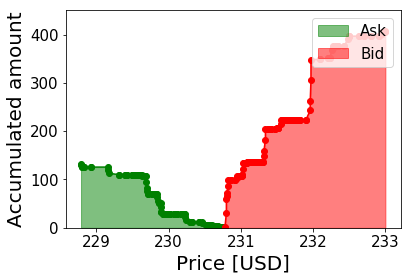

In [7]:
# FIGURE 

# snapshot of order book 

dta_minu = all_dta_minu[25]
print np.shape(dta_minu[0]), np.shape(dta_minu[1])

# print dta_minu[1]

concat_minu =  np.concatenate( [dta_minu[0], dta_minu[1]], 0 )
concat_minu = sorted(concat_minu, key = lambda x:x[0])

tmp_minu = np.transpose(concat_minu, [1,0])
# print np.shape(tmp_minu)

acc_amt = []
tmpsum = 0.0
for i in range(111, len(concat_minu)):
    tmpsum += concat_minu[i][1]
#     print concat_minu[i][1]
    acc_amt.append(tmpsum)
    
tmpsum = 0.0 
for i in range(110, -1, -1):
    tmpsum += concat_minu[i][1]
    acc_amt.insert(0, tmpsum)
    
# print acc_amt

fig, ax = plt.subplots()
ax.plot(tmp_minu[0][:111], acc_amt[:111], 'g', marker='o')

ax.plot(tmp_minu[0][111:], acc_amt[111:], 'r', marker='o')
#         ,  marker='o', linestyle='--', label = 'Auto-correlation', color = 'b')
# plt.title("Order book data from one minute")

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

ax.fill_between(tmp_minu[0][:111], [0]*len(concat_minu[:111]), acc_amt[:111], color='g',alpha=.5, label= 'Ask')
ax.fill_between(tmp_minu[0][111:], [0]*len(concat_minu[111:]), acc_amt[111:], color='r',alpha=.5, label= 'Bid')

ax.set_ylim([0,450])
# ax.set_xlim([225,235])


ax.set_ylabel('Accumulated amount', fontsize=20)
ax.set_xlabel('Price [USD]', fontsize=20)
ax.legend(loc=1,  prop={'size': 15})

fig.savefig('/media/guo/System/Users/guoti/tian-work-2017/paper_bc/figures/ob.eps')

(2,) (2,)


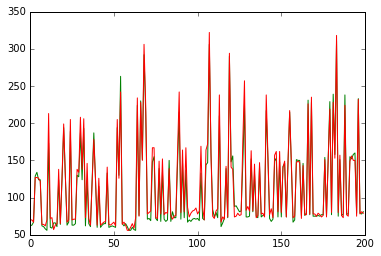

In [19]:


# number of asks and bids

dta_minu = all_dta_minu[1000:1200]
print np.shape(dta_minu[0]), np.shape(dta_minu[1])

# print dta_minu[1]

depth=[]
for i in dta_minu:
    depth.append( [ len(i[0]), len(i[1]) ] )
    
trans_depth = np.transpose(depth, [1,0])

fig, ax = plt.subplots()
ax.plot( trans_depth[0], 'g')

ax.plot( trans_depth[1], 'r')

# plt.title("Order book data from one minute")

# ax.set_ylabel('Amount', fontsize=13)
# ax.set_xlabel('Price (USD)', fontsize=13)
# ax.legend(loc=2)

# fig.savefig('/media/guo/System/Users/guoti/tian-work-2017/paper_bc/figures/ob.jpg')

(2,) (2,)


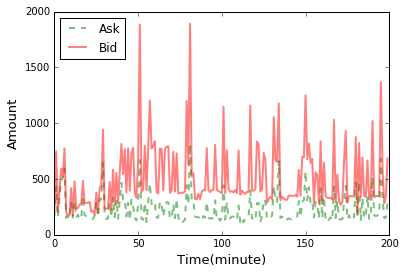

In [49]:
# total amount of bid and ask over each minute 

dta_minu = all_dta_minu[500:700]
print np.shape(dta_minu[0]), np.shape(dta_minu[1])

# print dta_minu[1]

depth=[]
for i in dta_minu:
    depth.append( [ sum([j[1] for j in i[0]]), sum([j[1] for j in i[1]]) ] )
    
trans_depth = np.transpose(depth, [1,0])

fig, ax = plt.subplots()
ax.plot(trans_depth[0], 'g', alpha=.5, label = 'Ask', linestyle='--', linewidth=2.0)

ax.plot(trans_depth[1], 'r', alpha=.5, label = 'Bid', linewidth=2.0)

# plt.title("Order book data from one minute")

ax.set_ylabel('Amount', fontsize=13)
ax.set_xlabel('Time(minute)', fontsize=13)
ax.legend(loc=2)

fig.savefig('/media/guo/System/Users/guoti/tian-work-2017/paper_bc/figures/amt_minute.jpg')

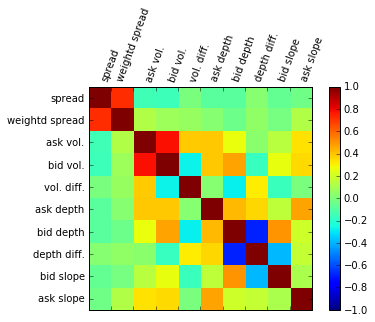

In [32]:
# Correlation Matrix of minute features 

correlations = pd.DataFrame(features_minu).corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)

ticks = np.arange(0.5,10)
ax.set_xticks(ticks)

ticks = np.arange(0,10,1)
ax.set_yticks(ticks)

ax.set_xticklabels(features_ob, rotation=70)
ax.set_yticklabels(features_ob)
plt.show()

In [8]:
# Distribution of mininute observations 
hour_inter = np.diff(all_loc_hour)
fig, ax = plt.subplots()

fig.set_size_inches( 5,5 )
bins = [i for i in range(0,61,5)]
tmp = ax.hist(hour_inter, bins, histtype='bar',  \
        label=['Normed hist'])
# ax.set_title('Price proposed by ask and bit requests on one minute', fontsize=13)
ax.set_xlabel('# of minute obs in hour', fontsize=13)
ax.set_xlim(0,60)
sns.set_style('whitegrid')
sns.kdeplot(np.array(hour_inter), bw=0.5, label='Density')
ax.legend()


# target variable distribution
fig, ax = plt.subplots()
fig.set_size_inches( 5,5 )
ax.hist(rvol_hour, histtype=
        'bar',  \
        label=['Normed hist'], bins = 30)
# ax.set_title('Price proposed by ask and bit requests on one minute', fontsize=13)
ax.set_xlabel('Return Volatility', fontsize=13)
ax.set_xlim(0,3)

sns.set_style('whitegrid')
# sns.kdeplot(np.array(rvol_hour), bw=0.5, label='Density')
ax.legend()


fig, ax1 = plt.subplots()
fig.set_size_inches( 5,5 )
ax1.hist(log( [i+1e-5 for i in rvol_hour] ), histtype='bar',    \
        label=['Normed hist'], bins =30)
# ax.set_title('Price proposed by ask and bit requests on one minute', fontsize=13)
ax1.set_xlabel('Log Return Volatility', fontsize=13)
# ax1.set_xlim(0,5)
sns.set_style('whitegrid')
# sns.kdeplot(np.array(rvol_hour), bw=0.5, label='Density')
ax1.legend()

# QQ plot 
# import numpy as np 
# import pylab 
# import scipy.stats as stats

# measurements = np.random.normal(loc = 20, scale = 5, size=100)   
# stats.probplot(measurements, dist="norm", plot=pylab)
# pylab.show()

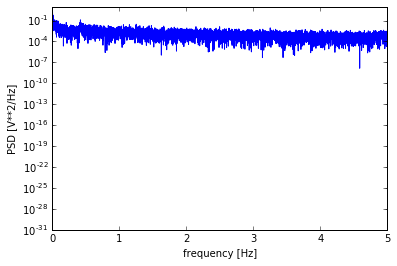

In [13]:
# Seasonality test

fs = 10
f, Pxx_den = signal.periodogram(rvol_hour, fs)
plt.semilogy(f, Pxx_den)
# plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

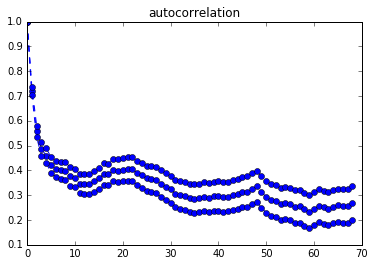

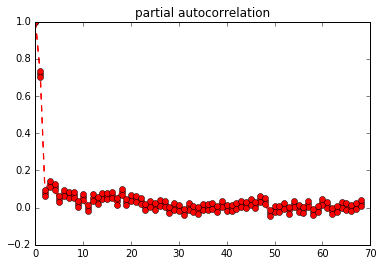

In [7]:
# Auto-correlaiton and Partial autocorrelation plot 

lag_corr  = acf(  rvol_hour, nlags = 68, alpha=0.05 )  
lag_pcorr = pacf( rvol_hour, nlags = 68, alpha=0.05  ) 

lag_corr = [ [i[0],i[1][0], i[1][1]] for i in zip(list(lag_corr[0]), list(lag_corr[1])) ]
lag_corr = np.asarray(lag_corr)

lag_pcorr = [ [i[0],i[1][0], i[1][1]] for i in zip(list(lag_pcorr[0]), list(lag_pcorr[1])) ]
lag_pcorr = np.asarray(lag_pcorr)


fig, ax = plt.subplots()
ax.plot(lag_corr,  marker='o', linestyle='--', label = 'Auto-correlation', color = 'b')
plt.title("autocorrelation")

fig, ax = plt.subplots()
ax.plot(lag_pcorr,  marker='o', linestyle='--', label = 'Auto-correlation', color = 'r')
plt.title('partial autocorrelation')
# ax.plot(lag_pcorr, marker='o', linestyle='--', label = 'Partial auto-correlation', color ='r')
# ax.legend()


In [5]:
# ARMA order check 

def ts_stationarize_diff( ts ):
    cur_ts = ts
    
    p_val = sm.tsa.stattools.adfuller(cur_ts,\
                                      regression='c', \
                                      maxlag=None, store=False)[1]
    diff_cnt = 0 
    while p_val > 0.01:
                
        pre_ts = cur_ts[1:]
        post_ts = cur_ts[:-1]
        
        diff_cnt += 1
        tmplen= len(pre_ts)
        cur_ts = [ pre_ts[i] - post_ts[i] for i in range(tmplen) ] 
        p_val = sm.tsa.stattools.adfuller(cur_ts,\
                                          regression='c', \
                                          maxlag=None, store=False)[1]
    return diff_cnt, p_val, cur_ts

def auto_arma(ar_range, x):
    
    aic_ar_ma = []
    for i in ar_range :
            
            model = sm.tsa.arima_model.ARIMA(x, order=(i, 0, 0))
            results = model.fit(disp= 1, trend = 'c', transparams=False, method="mle", verbose= False)
#             {‘css-mle’,’mle’,’css’}
            
            aic_ar_ma.append( [i, results.aic] )
            
            #print 'lag', i, results.aic, results.bic, results.pvalues
            
    return min(aic_ar_ma, key= lambda x: x[1])


def statistical_test(x):
    
    print 'Adfuller test:\n', sm.tsa.stattools.adfuller(x, regression='c', maxlag=None, store=False)
    print 'KPSS test:\n', sm.tsa.stattools.kpss(np.asarray(x),\
                                            regression='c', \
                                    lags=None, store=False)


In [6]:
# basic statistics property tests 

print statistical_test(rvol_hour)
# [1,3,4,16,18]

# Your data might have some level shift (the first half of the sample does not have quite the same level as 
# the second half) and perhaps some heteroskedasticity 

'''
# autoregressive order dynamics
order_seq = []
for i in range(1,9):
    order_seq.append(auto_arma([1,3,4,16,18], rvol_hour[(i-1)*1000 : i*1000]))

print order_seq

[[16, -5140.101292599884], [18, -2146.9425872982283], [16, -3005.067833567963],\
 [16, -2750.9339658705867], [18, -2075.317251929653],\
 [3, -2435.8597446882004], [18, -344.6574447281487], [4, -492.70567069939943]]

# test on a chosen lag 
model = sm.tsa.arima_model.ARIMA(rvol_hour[:1000], order=(16, 0, 2))
results = model.fit(disp= 1, trend = 'c', transparams=False, method="mle")
'''

Adfuller test:
(-8.9030939083019458, 1.1571008950628458e-14, 30, 13698, {'5%': -2.8617510241867143, '1%': -3.4308274803517085, '10%': -2.5668823233367233}, -25780.832106467322)
KPSS test:
(1.9868463069497297, 0.01, 42, {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347})
None


/home/guo/.local/lib/python2.7/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


'\n# autoregressive order dynamics\norder_seq = []\nfor i in range(1,9):\n    order_seq.append(auto_arma([1,3,4,16,18], rvol_hour[(i-1)*1000 : i*1000]))\n\nprint order_seq\n\n[[16, -5140.101292599884], [18, -2146.9425872982283], [16, -3005.067833567963], [16, -2750.9339658705867], [18, -2075.317251929653], [3, -2435.8597446882004], [18, -344.6574447281487], [4, -492.70567069939943]]\n\n# test on a chosen lag \nmodel = sm.tsa.arima_model.ARIMA(rvol_hour[:1000], order=(16, 0, 2))\nresults = model.fit(disp= 1, trend = \'c\', transparams=False, method="mle")\n'

In [15]:
roll_mean = pd.rolling_mean(results.resid, 50, min_periods=None, freq=None, center=True)  
roll_var = pd.rolling_var(results.resid, 50, min_periods=None, freq=None, center=True)  

fig, ax  = plt.subplots()
fig.set_size_inches( 15,5 )
ax.plot(roll_mean,  label = 'Rolling mean of Residuals' )
ax.legend()

fig1, ax1  = plt.subplots()
ax1.plot(roll_var,  label = 'Rolling variance of Residuals' )
ax1.legend()

NameError: name 'results' is not defined

In [ ]:
# print results.pvalues
fig, ax = plt.subplots()
fig.set_size_inches( 15,5 )

ax.plot(results.resid,  label='Residuals over time' )
ax.legend()

fig1, ax1 = plt.subplots()
ax1.hist(results.resid, histtype='bar', label='Residual distribution')
ax1.legend()

# Ljung–Box test on residuals to test no auto-correlation
print sm.stats.diagnostic.acorr_ljungbox(results.resid, lags=None, boxpierce=False)[1]

# Normality test
print sp.stats.mstats.normaltest(results.resid)
# ft += [tmp.pvalue, tmp.statistic]

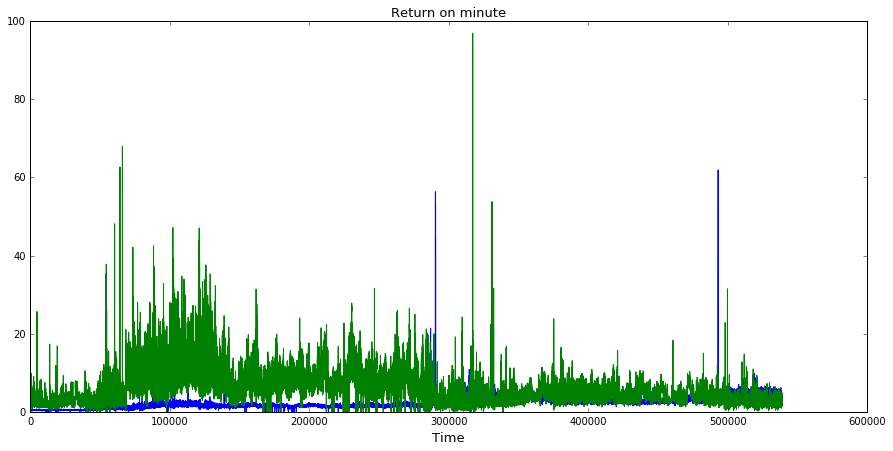

In [33]:
tmp = [[i[2], i[5]] for i in features_minu] 

fig, ax = plt.subplots() 
fig.set_size_inches((15,7))
ax.plot( tmp )
ax.set_title('Return on minute', fontsize=13)
ax.set_xlabel('Time', fontsize=13)
plt.legend()

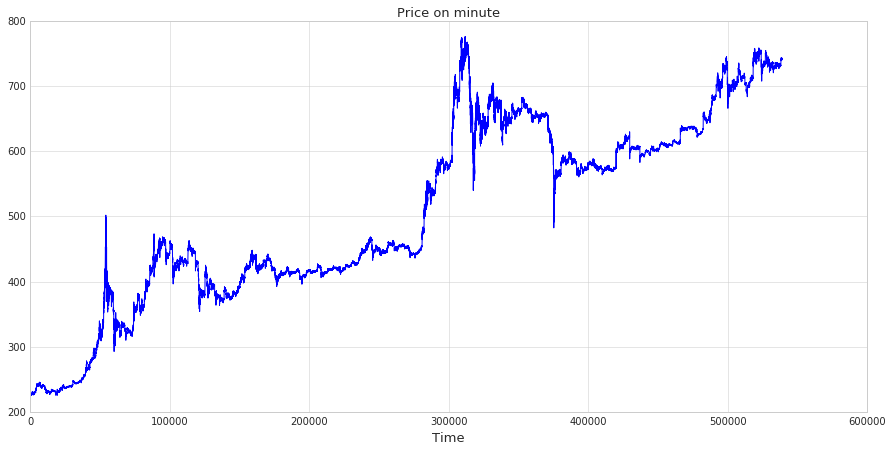

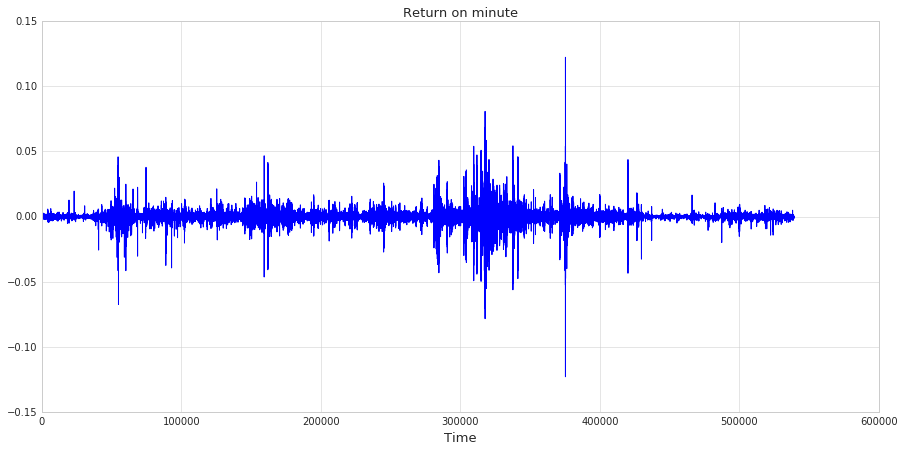

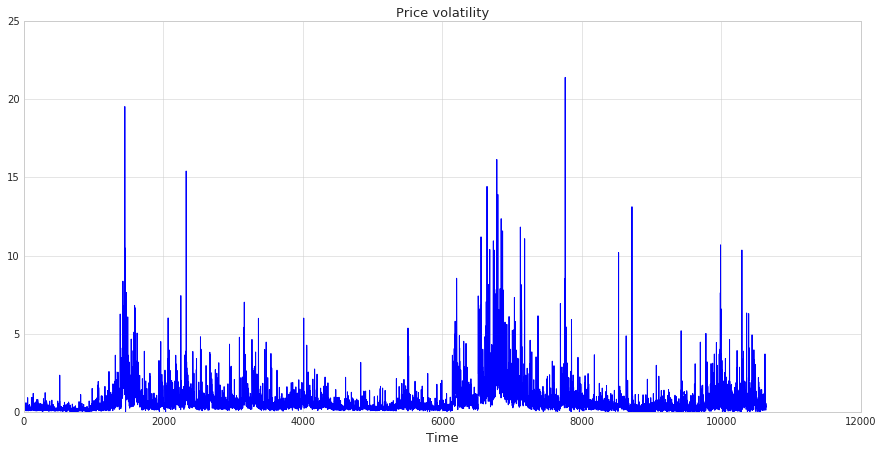

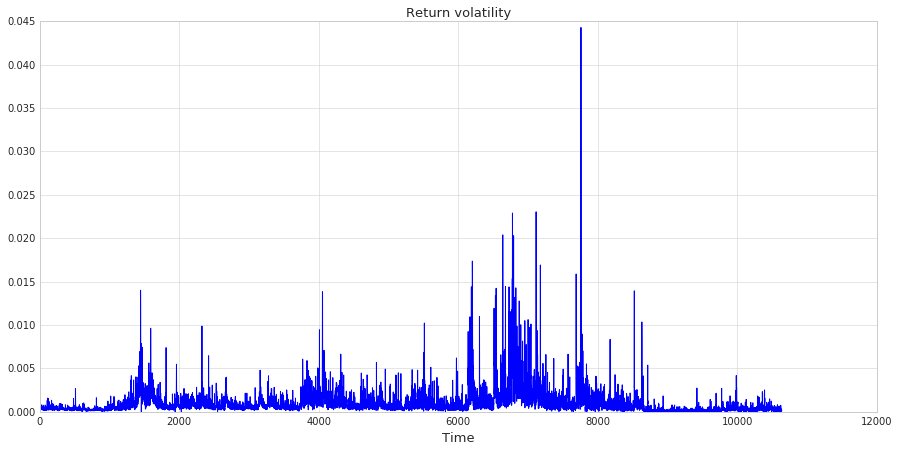

In [107]:
fig, ax = plt.subplots() 
fig.set_size_inches((15,7))
ax.plot( price_minu )
ax.set_xlabel('Time', fontsize=13)
ax.set_title('Price on minute', fontsize=13)

plt.legend()

diff = []
for i in range(1, len(price_minu)):
    diff.append( log(price_minu[i]*1.0/price_minu[i-1]) )
    
fig, ax = plt.subplots() 
fig.set_size_inches((15,7))
ax.plot( diff )
ax.set_title('Return on minute', fontsize=13)
ax.set_xlabel('Time', fontsize=13)
plt.legend()

fig, ax = plt.subplots() 
fig.set_size_inches((15,7))
ax.plot( pvol_hour )
ax.set_title('Price volatility', fontsize=13)
ax.set_xlabel('Time', fontsize=13)
plt.legend()

fig, ax = plt.subplots() 
fig.set_size_inches((15,7))
ax.plot( rvol_hour )
ax.set_title('Return volatility', fontsize=13)
ax.set_xlabel('Time', fontsize=13)
plt.legend()

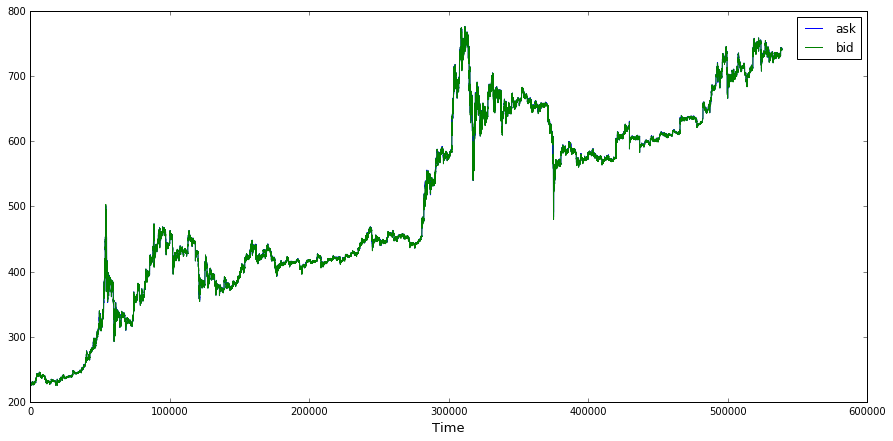

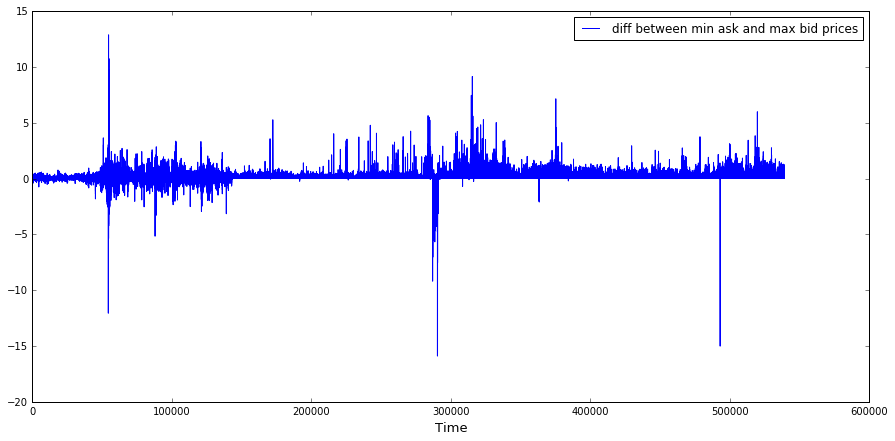

In [9]:
# --- test of extracted features w.r.t. minute ---

test_ask = [] 
test_bid = []
test_diff= []
for i in range( len(all_dta_minu) ):
    tmp_a = [ j[0] for j in all_dta_minu[i][0] ]
    tmp_b = [ j[0] for j in all_dta_minu[i][1] ]
    
    if tmp_a and tmp_b:
        test_ask.append( min(tmp_a) )
        test_bid.append( max(tmp_b) )
        test_diff.append( min(tmp_a)-max(tmp_b) )

fig, ax = plt.subplots() 
fig.set_size_inches((15,7))
ax.plot( test_ask , label = 'ask' )
ax.plot( test_bid , label = 'bid' )
ax.set_xlabel('Time', fontsize=13)
plt.legend()

fig1, ax1 = plt.subplots() 
fig1.set_size_inches((15,7))
ax1.plot( test_diff , label = 'diff between min ask and max bid prices' )
ax1.set_xlabel('Time', fontsize=13)
plt.legend()


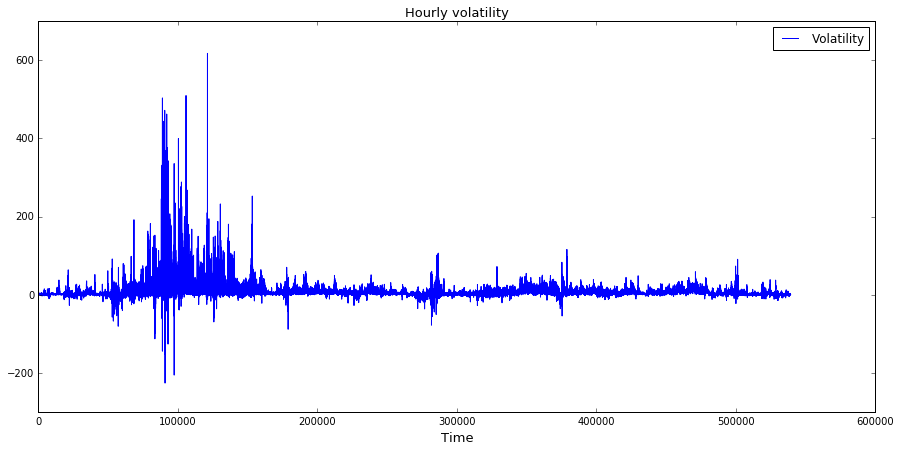

In [126]:
# Log-normal

fig1, ax1 = plt.subplots() 
fig1.set_size_inches((15,7))
ax1.plot( [i[4] for i in features_minu] , label = 'Volatility' )
ax1.set_title('Hourly volatility', fontsize=13)
# ax1.set_ylim(0,2)
ax1.set_xlabel('Time', fontsize=13)
plt.legend()

[380.0, 380.5, 381.0, 381.5, 382.0, 382.5, 383.0, 383.5, 384.0, 384.5, 385.0, 385.5, 386.0, 386.5, 387.0, 387.5, 388.0, 388.5, 389.0, 389.5, 390.0, 390.5, 391.0, 391.5, 392.0, 392.5, 393.0, 393.5, 394.0, 394.5, 395.0, 395.5, 396.0, 396.5, 397.0, 397.5, 398.0, 398.5, 399.0, 399.5, 400.0, 400.5]


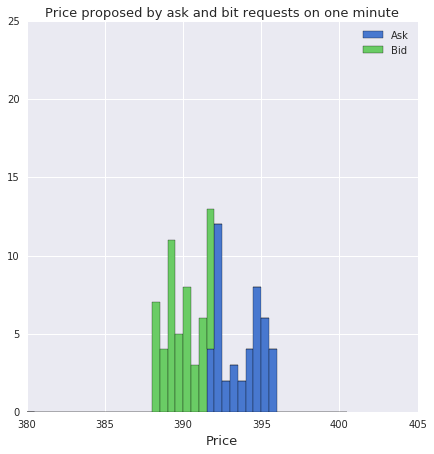

In [29]:
# ----- figure plot -----

import seaborn as sns
sns.set(style="darkgrid", palette="muted")

# --- histogram --- 
fig, ax = plt.subplots()
# ax0, ax1, ax2, ax3 = axes.flatten()
fig.set_size_inches( 7,7 )

# Make a multiple-histogram of data-sets with different length.
# x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
bin_edges = [ 380.0+ i*0.5 for i in range(42) ]
print bin_edges

ax.hist(price_minutes[0], bins = bin_edges, histtype='bar', rwidth = 1.0, stacked=True, \
        label=['Ask', 'Bid'])
ax.set_title('Price proposed by ask and bit requests on one minute', fontsize=13)
ax.set_xlabel('Price', fontsize=13)
ax.set_ylim(0,25)

ax.legend()

# fig.savefig('/media/guo/System/Users/guoti/tian-work-2017/amazon/hist_price.jpg', format='jpg',\
#             bbox_inches='tight')

# print bin_edges[1]
# # fig.tight_layout()
# plt.show()

# --- plot ---

fig = plt.figure()
fig.set_size_inches( figure_size )

ax = fig.add_subplot(111, xlabel='x', ylabel='y')

plt.plot( range(cnt),n_minu_hour )
#ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0)

# --- figure group ---

np.random.seed(19680801)

n_bins = 10
x = np.random.randn(1000, 3)

fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()

colors = ['red', 'tan', 'lime']
ax0.hist(x, n_bins, normed=1, histtype='bar', color=colors, label=colors)
ax0.legend(prop={'size': 10})
ax0.set_title('bars with legend')

ax1.hist(x, n_bins, normed=1, histtype='bar', stacked=True)
ax1.set_title('stacked bar')

ax2.hist(x, n_bins, histtype='step', stacked=True, fill=False)
ax2.set_title('stack step (unfilled)')


# Make a multiple-histogram of data-sets with different length.
x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
ax3.hist(x_multi, n_bins, histtype='bar')
ax3.set_title('different sample sizes')

fig.tight_layout()
plt.show()


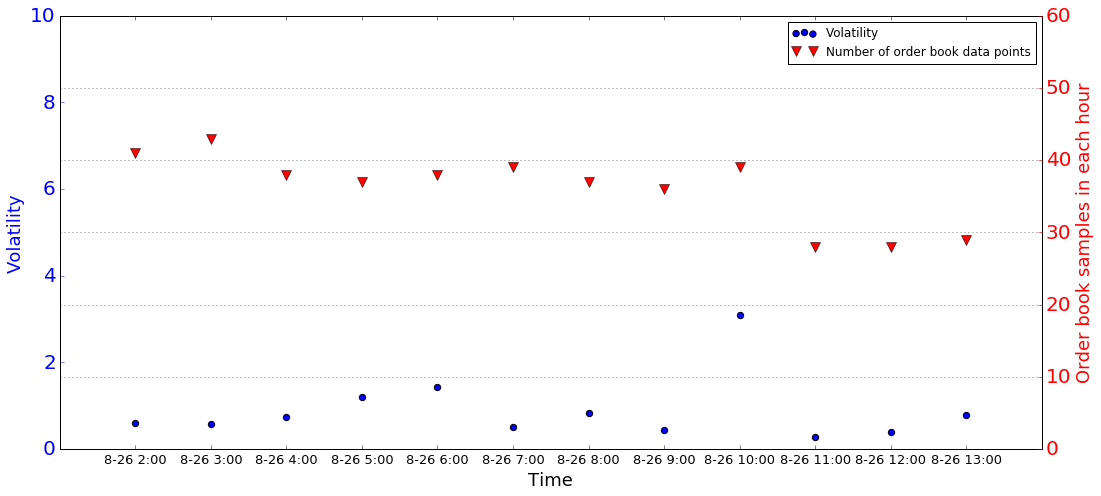

In [44]:
# import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

import matplotlib.ticker as ticker

labels = hour_tick

# sns.set(style="darkgrid", palette="muted")

figure_size = (15.4,7)
cnt = 12


fig, ax1 = plt.subplots() 
fig.set_size_inches( figure_size )

# ax1.scatter(vol_hour[:cnt])
lns1 = ax1.scatter(range(cnt), vol_hour[:cnt], s=40, label = 'Volatility' )
ax1.set_xlabel('Time: hour', fontsize= 18)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Volatility', color='b', fontsize=18)
ax1.set_ylim(0, 10)

ax1.tick_params('y', colors='b')
plt.tick_params(axis='y', which='both', labelsize=20)
plt.tick_params(axis='x', which='both', labelsize=13)


ax2 = ax1.twinx()
lns2 = ax2.plot(range(cnt), n_minu_hour, 'rv', markersize=10, label = 'Number of order book data points' )
ax2.set_ylabel('Order book samples in each hour', color='r', fontsize=18)
ax2.tick_params('y', colors='r')
ax2.set_ylim(0, 60)
# ax2.legend(loc=0)

plt.xticks( range(cnt), hour_tick[:cnt] )
ax1.set_xlim(-1,12)

plt.tick_params(axis='both', which='both', labelsize=20)
# plt.tick_params(axis='y', which='minor', labelsize=20)


h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=0)



fig.tight_layout()
plt.grid(True)
plt.show()

# fig.savefig('/media/guo/System/Users/guoti/tian-work-2017/amazon/vola_samples.jpg', format='jpg',\
#             bbox_inches='tight')

[0, 1, 2, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 19, 20, 22, 23, 24, 25, 28, 29, 30, 31, 33, 34, 35, 38, 39, 40, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 55, 57]
[0, 1, 3, 4, 5, 7, 10, 11, 12, 13, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 33, 35, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 51, 55, 56]


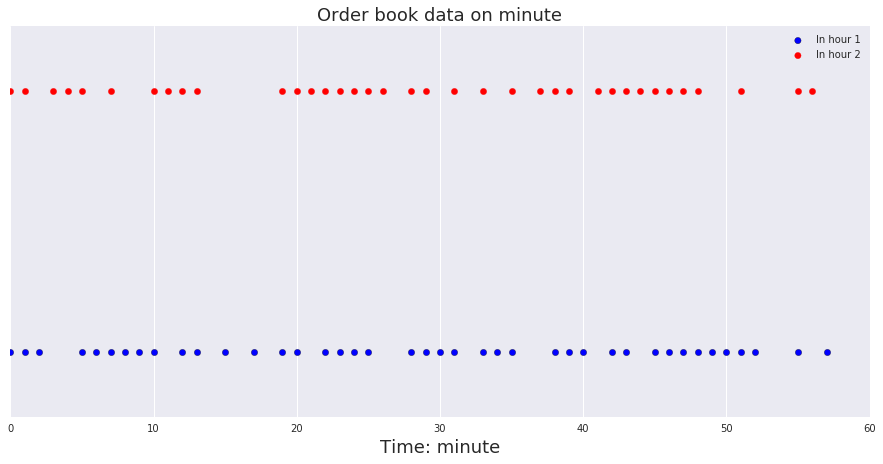

In [55]:
# minute ticks

sns.set(style="darkgrid", palette="muted")

minute_ticks = hour_unaggre[:3]

mtick1 = [i[4] for i in hour_unaggre[0]]
mtick2 = [i[4] for i in hour_unaggre[3]]
print mtick1
print mtick2

fig, ax1 = plt.subplots() 
fig.set_size_inches( figure_size )
plt.title('Order book data on minute', fontsize=18)

# ax1.scatter(vol_hour[:cnt])
ax1.scatter( mtick1, [1]*len(mtick1), s=40, label = 'In hour 1' )
ax1.set_xlabel( 'Time: minute', fontsize= 18 )
# Make the y-axis label, ticks and tick labels match the line color.
# ax1.set_ylabel('Volatility', color='b', fontsize=18)
ax1.set_xlim(0, 60)
ax1.scatter( mtick2, [1.2]*len(mtick2), s=40, color='r', label='In hour 2' )
plt.yticks([])
plt.legend()

# fig.savefig('/media/guo/System/Users/guoti/tian-work-2017/amazon/minu_ticks.jpg', format='jpg',\
#             bbox_inches='tight')


41 [36, 37, 38, 72, 74, 35, 38, 34, 35, 36, 34, 99, 32, 34, 69, 107, 35, 42, 40, 41, 42, 38, 42, 83, 41, 68, 37, 72, 36, 38, 36, 73, 41, 85, 38, 39, 74, 36, 83, 71, 108]
41 [47, 48, 46, 100, 113, 47, 48, 50, 47, 52, 51, 140, 48, 48, 98, 154, 51, 44, 46, 48, 48, 51, 51, 106, 53, 102, 47, 104, 52, 48, 51, 101, 51, 102, 43, 50, 108, 57, 110, 93, 125]


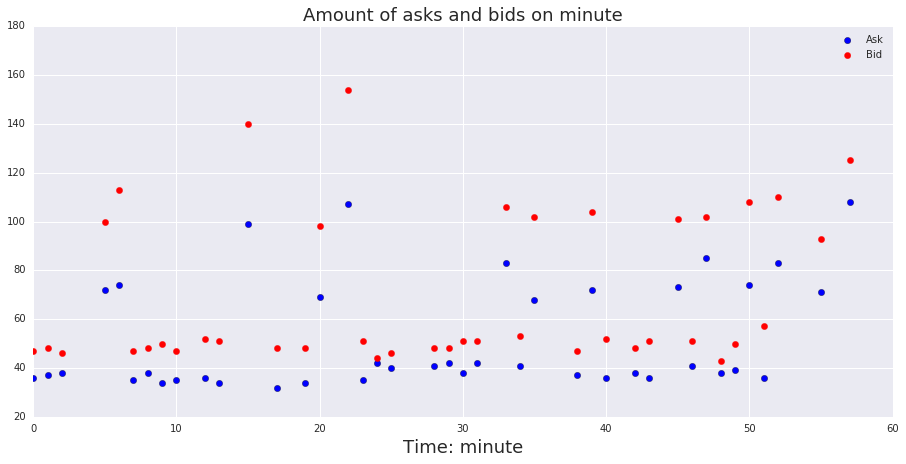

In [56]:
# number of samples in each minute

# number of ask in consecutive minutes
n_ask =  [len(i[0]) for i in hour_unaggre[0]]
print len(n_ask), n_ask 

# number of bid in consecutive minutes
n_bid = [len(i[2]) for i in hour_unaggre[0]]
print len(n_bid), n_bid

mtick = [i[4] for i in hour_unaggre[0]]


fig, ax1 = plt.subplots() 
fig.set_size_inches( figure_size )
plt.title('Amount of asks and bids on minute', fontsize=18)


# ax1.scatter(vol_hour[:cnt])
ax1.scatter( mtick, n_ask, s=40, label = 'Ask' )
ax1.set_xlabel( 'Time: minute', fontsize= 18 )
# Make the y-axis label, ticks and tick labels match the line color.
# ax1.set_ylabel('Volatility', color='b', fontsize=18)
ax1.set_xlim(0, 60)
ax1.scatter( mtick, n_bid, s=40, color='r', label='Bid' )
# plt.yticks([])
plt.legend()

# fig.savefig('/media/guo/System/Users/guoti/tian-work-2017/amazon/minu_ask_bid.jpg', format='jpg',\
#             bbox_inches='tight')


In [52]:
# irregular time intervals in miniutes 
for i in range(10):
    tmp_date = datetime.datetime.fromtimestamp(uni_ts[i]/1000.0)
    print tmp_date,tmp_date.date()
    